# TIME DOMAIN SOLUTION FOR OSCILLATING REACTION NETWORK

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Reaction Network
<img src="Fig1.png" alt="Reaction Network" width="500"/>

# Notation

* ${\bf A}$ - Jacobian matrix
* $\alpha_n$ - amplitude of oscillation for species $n$
* $\Delta$ - $det {\bf A})$
* $i$ - indexes constants
* $k_i$, $k_d$ - positive constant
* $K$ - number of constants
* $\lambda$ - eigenvalue
* $n$ - indexes species
* $N$ - number of species
* $\omega_n$ - offset of species $n$
* $\phi_n$ - phase in radians
* $\tau$ - $tr({\bf A})$
* $\theta$ - frequency in radians
* ${\bf u}$ - forced input (kinetic constants for zeroth order rates)
* ${\bf x}$ ($N \times 1$) is the state vector
* $x_n$ (t) - time varying concentration of species $n$

Linear system
\begin{equation}
\dot{\bf x} = {\bf A} {\bf x} + {\bf u}\label{eq:linear}
\end{equation}

Notes
1. From the foregoing definitions, the oscillating characteristics are $\{\alpha_n, \theta, \phi_n, \omega_n \}$. So, there 7 OCs.
1. The parameters of the network are the $k_i$, $x_n (0)$. So, there are 8 parameters.

# Programming Preliminaries

In [2]:
from src.Oscillators import c1, c2, T, phi, r1, r2, t, b1, b2, m1, m2, h1, h2,   \
    alpha, omega, theta, S1, S2, k1, k2, k3, k4, k5, k6, k_d, x1, x1_0, x2, x2_0, I
from src.Oscillators import util
from src.Oscillators.util import TIMES
from src.Oscillators.oscillator_solution import OscillatorSolution
from src.Oscillators.model import MODEL, PARAM_DCT

import tellurium as te
import sympy
from sympy import init_printing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import control
import lmfit

init_printing()

In [3]:
PARAM_DCT

{'k1': 1.0,
 'k2': 39.47841760435743,
 'k3': 40.47841760435743,
 'k4': 5.0,
 'k5': 41.47841760435743,
 'k6': 5.0,
 'k_d': 1.0,
 'theta': 6.283185307179586,
 'x1_0': 1.0,
 'x2_0': 10.0}

In [4]:
SOLUTION = OscillatorSolution()
_ = SOLUTION.getSolution()
SYMBOL_DCT = util.makeSymbolDct(SOLUTION.x_vec, PARAM_DCT)
SYMBOL_DCT

In [5]:
#TIMES = [0.01*n for n in range(500)]

In [6]:
if False:
    c1, c2, T, phi, r1, r2, t, b1, b2, m1, m2, h1, h2 =   \
       sympy.symbols("c1, c2, T, phi, r1, r2, t, b1, b2, m1, m2, h1, h2 ", real=True)
    c1, c2 = sympy.symbols("c1, c2")
    alpha, omega, theta, S1, S2, k1, k2, k3, k4, k5, k6, k_d, x1, x1_0, x2, x2_0 =   \
        sympy.symbols("alpha, omega, theta, S1, S2, k1, k2, k3, k4, k5, k6, k_d, x1, x1_0, x2, x2_0 ", real=True, positive=True, nonzero=True)

# Antimony Model of the Oscillating Reaction Network

Below, we construct a simulation model of the reaction network in the Antimony language. The simulation results are used to check steps in the analytical derivations.

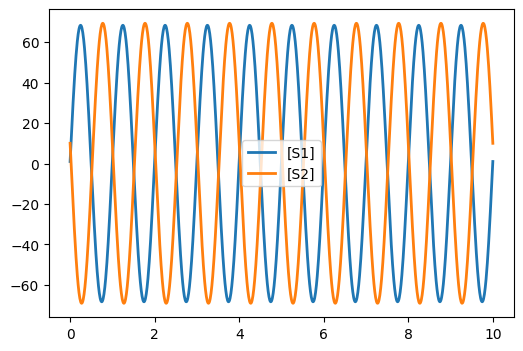

In [7]:
rr = te.loada(MODEL)
for k, v in PARAM_DCT.items():
    if k in rr.keys():
        try:
            rr[k] = v
        except Exception as exp:
            print("Could not set value for %s, %s" % (k, str(v)))
data = rr.simulate(0, 10, 1000)
rr.plot(data)

In [8]:
rr.getFullJacobian()

            S1,       S2
S1 [[  39.4784,  39.4784],
S2  [ -40.4784, -39.4784]]

In [9]:
np.linalg.eigvals(rr.getFullJacobian())

array([7.15919175e-14+6.28318531j, 7.15919175e-14-6.28318531j])

In [10]:
PARAM_DCT

{'k1': 1.0,
 'k2': 39.47841760435743,
 'k3': 40.47841760435743,
 'k4': 5.0,
 'k5': 41.47841760435743,
 'k6': 5.0,
 'k_d': 1.0,
 'theta': 6.283185307179586,
 'x1_0': 1.0,
 'x2_0': 10.0}

# Helpers

In [11]:
def pp(arr):
    print(pd.DataFrame(arr))

In [12]:
def makeTimes(start_time=0, end_time=5.0, point_density=20):
    return [1/point_density*n for n in range(start_time, point_density*end_time+1)]
# TESTS
end_time = 10
point_density = 2
times = makeTimes(end_time=end_time, point_density=point_density)
assert(len(times) == point_density*end_time+1)

In [13]:
# Simulation of the model
def simulateLinearSystem(A=None, B=None, end_time=20, is_plot=True):
    """
    Simulates the linear system specified by A and B
    """
    if A is None:
        A = np.array([ [PARAM_DCT["k1"] - PARAM_DCT["k2"], PARAM_DCT["k4"]],
                           [PARAM_DCT["k2"] - PARAM_DCT["k3"], - PARAM_DCT["k4"] ] ])
    if B is None:
        B = np.eye(2)
    C = np.eye(2)
    D = 0*np.eye(2)
    sys = control.StateSpace(A, B, C, D)
    sys = control.LinearIOSystem(sys, inputs=["S1", "S2"], outputs=["S1", "S2"])
    X0 = [1, 10]
    times = makeTimes(end_time=end_time)
    response = control.input_output_response(sys, T=times, X0=X0)
    plt.plot(response.t, response.y[0])
    plt.plot(response.t, response.y[1])
    plt.legend(["S1", "S2"], loc="upper left")
    if not is_plot:
        plt.close()
    
# Tests
simulateLinearSystem(is_plot=False)

In [14]:
def simulateSymbol(sym, dct, times=TIMES, is_plot=True):
    """
    Simulates a symbol that is a function of time.
    The time symbol must be "t".
    
    Parameters
    ----------
    sym: sympy.Symbol
    t: sympy.Symbol
    dct: dict (substitutions)
    
    Returns
    -------
    list-float
    """
    # Find the time symbol
    time_syms = [a for a in sym.atoms() if str(a) == "t"]
    if len(time_syms) == 0:
        raise ValueError("No time found!")
    if len(time_syms) > 1:
        raise ValueError("Multiple times found!")
    t = time_syms[0]
    # Simulation of ivp_solution
    new_sym = sym.subs(dct)
    vals = [float(sympy.simplify(new_sym.subs(t, v))) for v in times]
    if is_plot:
        plt.plot(times, vals)
    return vals

values = simulateSymbol(t, {}, is_plot=False)
np.testing.assert_array_equal(values, TIMES)
print("OK!")

OK!


In [15]:
def simulateSymbolVector(vec, dct, end_time=round(TIMES[-1]), is_plot=True):
    """
    Simulates a 2-d vector symbol that is a function of time.
    The time symbol must be "t".
    
    Parameters
    ----------
    sym: sympy.Symbol
    dct: dict (substitutions)
    """
    times = makeTimes(end_time=end_time)
    s1_vals = simulateSymbol(vec[0], dct, times=times)
    s2_vals = simulateSymbol(vec[1], dct, times=times)
    #
    plt.plot(times, s1_vals)
    plt.plot(times, s2_vals)
    _ = plt.legend(["S1", "S2"])
    if not is_plot:
        plt.close()
    
vec = sympy.Matrix([t, t**2])
_ = simulateSymbolVector(vec, {}, is_plot=False)
print("OK!")

OK!


In [16]:
def simulateRR(dct={}, is_plot=True):
    """
    Simulates the model with parameter updates as indicated.
    """
    rr = te.loada(MODEL)
    for key, value in PARAM_DCT.items():
        if key in rr.keys():
            rr[key] = value
    for key, value in dct.items():
        if key in rr.keys():
            rr[key] = value
    data = rr.simulate(0, 5, 1000)
    for col in data.colnames[1:]:
        plt.plot(data[:, 0], data[col])
    plt.legend(data.colnames[1:])
    if not is_plot:
        plt.close()
    
# Tests
simulateRR(is_plot=False)
print("OK!")

OK!


In [17]:
def makeSymbolDct(expression, name_dct, exclude_names=None):
    """
    Creates a dictionary whose keys are symbols in the expression with the same name.
    """
    if exclude_names is None:
        exclude_names = []
    convert_dct = {s.n: s for s in expression.free_symbols}
    dct = {}
    for sym in convert_dct.values():
        if sym.name in exclude_names:
            continue
        if not sym.name in name_dct.keys():
            continue
        dct[sym] = name_dct[sym.name]
    #
    return dct
# Tests
dct = makeSymbolDct(theta*k_d, PARAM_DCT, exclude_names=["t"])
assert(dct[theta] == PARAM_DCT["theta"])
print("OK!")

OK!


In [18]:
def findSinusoidCoefficients(expression):
    # FIXME: can do collect on the term that has the 0 power
    """
    Finds the coefficients of the sinusoids.
    
    Args:
        expression: sympy.expression
    Assumes:
        The symbols t, theta are defined symbols  
    Returns:
        dct
            key: "a" (coefficient of cosine), "b" (coefficient of sine), "c" (constant coefficient)
            value: expression
    """
    A = "a"
    B = "b"
    C = "c"
    def makeDct(expr, term):
        """
        Creates a dictionary that has the coefficients of the term
        """
        tt = sympy.Symbol("tt")
        new_expr = expr.subs({term: tt})
        collected = sympy.Poly(new_expr, tt).as_expr()
        i, d = collected.as_independent(tt, as_Add=True)
        rv = dict(i.as_independent(tt, as_Mul=True)[::-1] for i in sympy.Add.make_args(d))
        if i:
            assert 1 not in rv
            rv.update({sympy.S.One: i})
        rv[0] = rv[1].as_expr()
        del rv[1]
        rv[1] = rv[tt].as_expr()
        del rv[tt]
        return rv
    # 
    # Make the sine dictionary
    sin_dct = makeDct(expression, sympy.sin(t*theta))
    cosine_dct = makeDct(sin_dct[0], sympy.cos(t*theta))
    # Create the result
    result_dct = dict(cosine_dct)
    result_dct[A] = result_dct[1].as_expr()
    del result_dct[1]
    result_dct[B] = sin_dct[1].as_expr()
    result_dct[C] = result_dct[0].as_expr()
    del result_dct[0]
    return result_dct

# TESTS
expression = sympy.cos(t*theta)*k1*k2 + sympy.sin(t*theta)*k1*k2 + k5*k6
dct = findSinusoidCoefficients(expression)
for key in ["a", "b", "c"]:
    assert key in dct.keys()
print("OK!")

OK!


# Solution Details

Let ${\bf A} =
\begin{pmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{pmatrix}
$
Denote the determinant by $det({\bf A}) = \Delta = a_{11} a_{22} - a_{12} a_{21}$
and the trace by $\tau = tr({\bf A}) = a_{11} + a_{22}$. The eigenvalues are
$\lambda = \frac{1}{2} \left( - \tau \pm \sqrt{\tau^2 - 4 \Delta} \right)$.
So, to get pure imaginary eigenvalues, $\tau = 0$
and $\Delta > 0$.

<img src="Fig1.png" alt="Reaction Network" width="500"/>

## System Equations

In the sequel, we sometimes use $S_n$ to denote $x_n (t)$ to better draw out the connection between the reaction network and the system of differential equations for its solution.

This system equations are:
$
\begin{eqnarray}
\dot{S}_1 & = & - k_1 S_1 + +k_2 S_2 + k_3 S_1 - k_4 \\
\dot{S}_2 & = & k_1 S_1 - k_2 S_2 - k_5 S_1 + k_6  \\
\end{eqnarray}
$

Let ${\bf x} = 
\begin{pmatrix}
S_1 \\
S_2 \\
\end{pmatrix}
$,
$
{\bf A} = 
\begin{pmatrix}
k_3 - k_1 & k_2 \\
k_1 - k_5 & -k_2 \\
\end{pmatrix}
$, and
${\bf u} = 
\begin{pmatrix}
- k_4 \\
k_6  \\
\end{pmatrix}$

The full model is:
$\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.

Note that
\begin{eqnarray}
\tau & = & k_3 -k_1 - k_2 \\
\Delta & = & (k_3 - k_1)(-k_2) - k_2 (k_1 - k_5) \\
& = & k_2 (k_5 - k_3) \\
\end{eqnarray}

## Constraints 

The following constraints are required to obtain a biologically plausible oscillating reaction network whose solution is a linear ODE:
* C1: The rate laws of the reaction network are a linear function of ${\bf x} (t)$, which we also denote by $S_n$.
* C2: $x_n(t) \geq 0$
* C3: $\tau = 0$
* C4: $\Delta > 0$

## Implications of the constraints

**C3 implies that $k_3 = k_1 + k_2$**

**C4 implies that $k_5 > k_3$. We define $k_d = k_5 - k_3 > 0$.**

Applying the foregoing to the ${\bf A}$ matrix, we first note that
\begin{align*}
k_1 - k_5 & = & k_1 - k_3 -k_d \\
& = & k_3 - k_2 - k_3 - k_d \\
& = & -k_2 - k_d \\
\end{align*}
And so,
$
{\bf A} =
\begin{pmatrix}
k_2 & k_2 \\
-k_2 - k_d & -k_2 \\
\end{pmatrix}
$, and $\Delta = k_2 k_d$.

Recall, that with the constraints, the eigevalues are $\pm \sqrt{- \Delta}$.
Thus, the frequency of oscillation is
\begin{equation}
\theta = \sqrt{\Delta} = \sqrt{k_2 k_d} \label{eq:theta}
\end{equation}

We can check this result with a simulation.

In [19]:
A = SOLUTION.A_mat

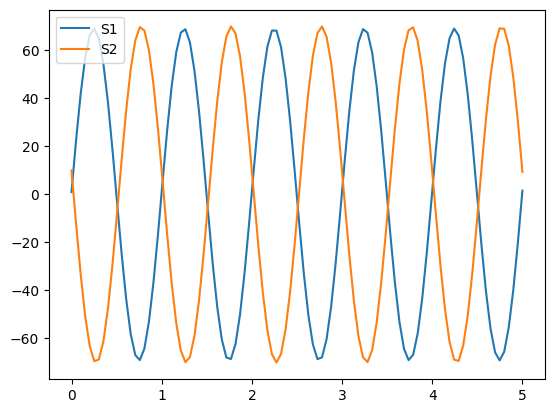

In [20]:
util.simulateLinearSystem(A=A.subs(SYMBOL_DCT), end_time=5)

## Eigenvectors for Pure Imaginary Eigenvalues

Note that since $k_d > 0$, ${\bf A}$ is nonsingular.

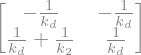

In [21]:
A.inv()

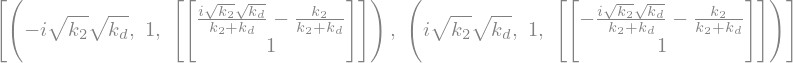

In [22]:
A.eigenvects()

The eigenvalues are:

$
\begin{eqnarray}
\lambda_1 &=& - \sqrt{k_d k_2} i \\
\lambda_2 &=&  + \sqrt{k_d k_2} i
\end{eqnarray}
$

We define $\theta = \sqrt{k_d k_2}$, and so
$\lambda_n = (-1)^n \theta i$.

The eigenvectors are:
$
{\bf e}  =
\begin{pmatrix}
\frac{- k_2 \pm \theta i}{k_2 + k_d} \\
1 \\
\end{pmatrix} \\
$

## Fundamental Matrix (${\bf F}$)

The fundamental matrix ${\bf F}$ is a marix with columns that are orthogonal solutions to the homogeneous system.

If the eigenvector ${\bf w}$ and/or
eigenvalue $\lambda$ are complex, then
${\bf w} e^{\lambda} = {\bf v}_1 + i {\bf v}_2$ for
some real vectors ${\bf v}_n$.
By theorem, the ${\bf v}_n$ are independent solutions to
the differential equation
and so the solution to the IVP
is $\sum_{n=1}^2 c_n v_n$ for $c_n$ chosen
based on the initial values.
Hence, ${\bf F} =
\left[ \begin{matrix} {\bf v}_1 & {\bf v}_2 \\ \end{matrix} \right]$.

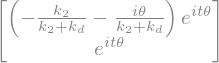

In [23]:
# Construct one eigenvector for the homogeneous IVP solution
w_vec = sympy.Matrix([ [-k2/(k2 + k_d) - theta*I/(k_d + k2)], [1]])*(sympy.exp(I*theta*t))
w_vec

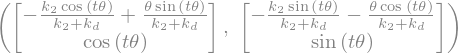

In [24]:
vecs = w_vec.as_real_imag()
vecs

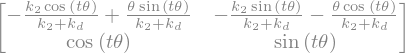

In [25]:
FUND_MAT = sympy.Matrix([ [vecs[0][0], vecs[1][0]], [vecs[0][1], vecs[1][1]]])
FUND_MAT  # Fundamental matrix

${\bf F} = \left[\begin{matrix}\frac{a \sin{\left(a t \right)}}{d + k_{4}} 
                 - \frac{k_{4} \cos{\left(a t \right)}}{d + k_{4}} & 
                 - \frac{a \cos{\left(a t \right)}}{d + k_{4}} - \frac{k_{4} \sin{\left(a t \right)}}{d 
                + k_{4}}\\\cos{\left(a t \right)} & \sin{\left(a t \right)}\end{matrix}\right]$



## Solution for Nonhomogeneous System

The equation with forced inputs is $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$,
where ${\bf u}$ is the forced input.
The solution with forced inputs has the form
${\bf x}^H + {\bf x}^P$, where ${\bf x}^H$
is a solution to the homogeneous system and ${\bf x}^P$ is a particular solution
for the forced input ${\bf u}$.

Recall the following for solutions of nonhomogeneous systems.
Let ${\bf F}$ be the fundamental matrix for $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.
We want to construct a particular solution
${\bf x}^P = {\bf F} {\bf v}$, for the unknown vector ${\bf v}$.

Substituting,

\begin{eqnarray}
\dot{\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf A} {\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf F} \dot{\bf v} & = & {\bf u} \\
{\bf v} = \int \left( {\bf F}^{-1} {\bf u} \right)dt
\end{eqnarray}

Note that there is an integration constant as well, but this need not be considered
since all values of the constant still result in a valid particular solution.
Also, the inverse exists since the columns of ${\bf X}_F$ are orthogonal.

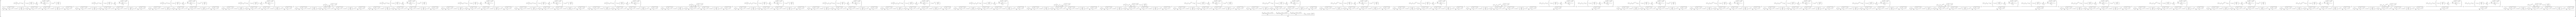

In [26]:
U_VEC = SOLUTION.u_vec
rhs = sympy.simplify(FUND_MAT.inv()*U_VEC)
rhs = sympy.integrate(rhs, t)
rhs

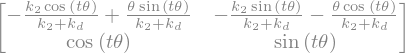

In [27]:
FUND_MAT

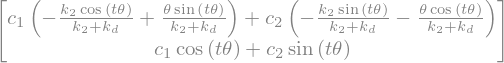

In [28]:
xhh = FUND_MAT*sympy.Matrix([[c1], [c2]])
xhh

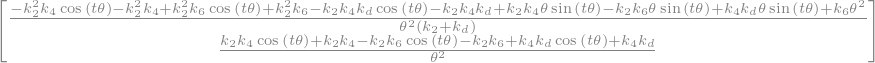

In [29]:
xp = sympy.simplify(FUND_MAT*rhs)
xp

In [30]:
k1*k2**2 + theta == 2*theta + k2**2*k1 - theta

True

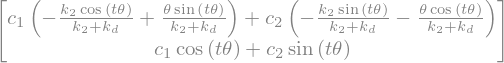

In [31]:
xhh

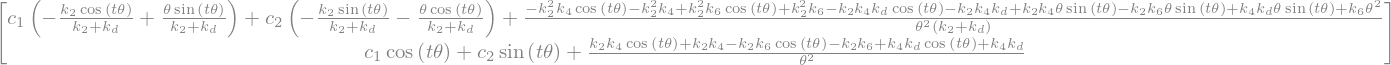

In [32]:
nonh_solution = xhh + xp
nonh_solution

In [33]:
cdct = sympy.solve(nonh_solution.subs(t, 0) - sympy.Matrix([ [x1_0], [x2_0]]), [c1, c2])

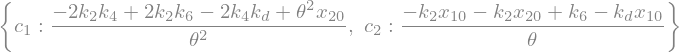

In [34]:
cdct

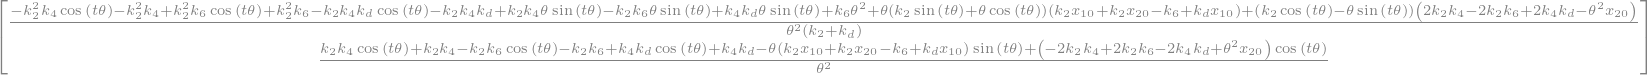

In [35]:
nonh_solution = nonh_solution.subs(cdct)
nonh_solution = sympy.simplify(nonh_solution)
nonh_solution

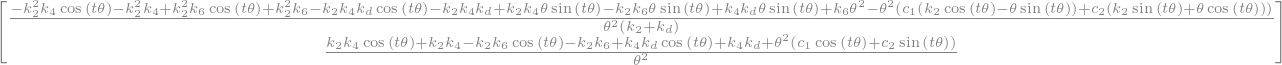

In [36]:
sympy.simplify(SOLUTION.raw_x_vec)

``nonh_solution`` has the form
$a_n sin(t \theta) + b_n cos(t \theta)  + \omega_n$. Below we find $a_n$, $b_n$, $\omega_n$.

$a_1 = \frac{\theta}{k_d + k_2} \left( x_2 (0) - \frac{k_d k_4 + k_2 k_4 - k_2 k_6}{\theta^2}\right)
- \frac{k_2}{k_d + k_2}$

## Restructuring the Nonhomogeneous Solution

To goal here is to restructure the solution to isolate the OCs. We take advantage of the following trigonometric equality.

$$a cos(t) + b sin(t) = \sqrt{a^2 + b^2} sin(t + tan^{-1}\frac{a}{b})
$$

In [37]:
def calculateAmplitudePhase(dct):
    """
    Calculates the amplitude and phase.
    """
    a = dct["a"]
    b = dct["b"]
    amplitude = sympy.sqrt(a**2 + b**2)
    phase = sympy.atan(a/b)
    return sympy.simplify(amplitude), sympy.simplify(phase.as_expr())

tt = sympy.Symbol("tt")
uu = sympy.Symbol("uu")
dct = {"a": tt, "b": uu*tt}
amp, phase = calculateAmplitudePhase(dct)
assert("sympy" in str(type(amp)))
assert("atan" in str(type(phase)))
print("OK!")

OK!


In [41]:
def makeSinFunction(expression_vec, name_dct=None):
    """
    Transforms the vector expression in terms of cos(theta*t), sin(theta*t) into a function of sin(theta*t + phi)
    
    Args:
        expression_vec: sympy vector Expression
        name_dct: string, values for substituions
    Returns:
        2X1 vector of expressions
    """
    if name_dct is not None:
        symbol_dct = makeSymbolDct(expression_vec, name_dct)
    else:
        symbol_dct = None
    def calculateTimeFunction(expr):
        dct = findSinusoidCoefficients(expr)
        amplitude, phase = calculateAmplitudePhase(dct)
        phase_offset = 0
        if symbol_dct is not None:
            b_subs = dct["b"].subs(symbol_dct)
            if b_subs < 0:
                phase_offset = sympy.pi
        func = amplitude*sympy.sin(theta*t + phase_offset + phase) + dct["c"]
        return func
    #
    x1 = calculateTimeFunction(expression_vec[0])
    x2 = calculateTimeFunction(expression_vec[1])
    return sympy.Matrix([ [x1], [x2] ])

# Tests
if False:
    soln = makeSinFunction(nonh_solution, name_dct=PARAM_DCT)
    vector_func = soln.subs(symbol_dct)
    p1 = sympy.plotting.plot(vector_func[0], xlim=[0, 10], line_color="red", show=False)
    p2 = sympy.plotting.plot(vector_func[1], xlim=[0, 10], line_color="blue", show=False)
    p1.append(p2[0])
    p1.show()

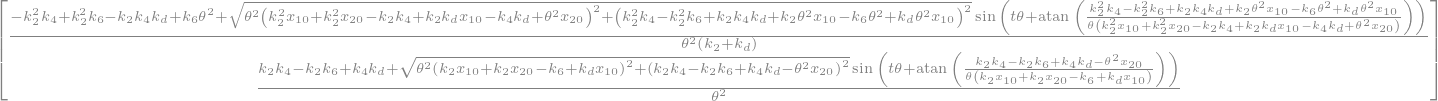

In [42]:
soln = sympy.simplify(makeSinFunction(nonh_solution))
soln

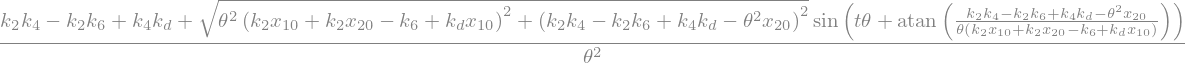

In [43]:
soln[1]

In [44]:
print(sympy.python(soln[1]))

k2 = Symbol('k2')
k4 = Symbol('k4')
k6 = Symbol('k6')
k_d = Symbol('k_d')
theta = Symbol('theta')
x1_0 = Symbol('x1_0')
x2_0 = Symbol('x2_0')
t = Symbol('t')
e = (k2*k4 - k2*k6 + k4*k_d + sqrt(theta**2*(k2*x1_0 + k2*x2_0 - k6 + k_d*x1_0)**2 + (k2*k4 - k2*k6 + k4*k_d - theta**2*x2_0)**2)*sin(t*theta + atan((k2*k4 - k2*k6 + k4*k_d - theta**2*x2_0)/(theta*(k2*x1_0 + k2*x2_0 - k6 + k_d*x1_0)))))/theta**2


# Designing an Oscillator

The approach here is to use optimization as a way to search for parameters of the reaction network that produce the desired OCs.

In [45]:
parameters = lmfit.Parameters()
names = ["k2", "k6", "k4", "k_d", "x20", "x10"]
for name in names:
    parameters.add(name, min=1e-3, max=1e3, value = 1)
parameters

name,value,initial value,min,max,vary
k2,1.00000000,1,1.0000e-03,1000.00000,True
k6,1.00000000,1,1.0000e-03,1000.00000,True
k4,1.00000000,1,1.0000e-03,1000.00000,True
k_d,1.00000000,1,1.0000e-03,1000.00000,True
x20,1.00000000,1,1.0000e-03,1000.00000,True
x10,1.00000000,1,1.0000e-03,1000.00000,True


In [46]:
def makeResidualCalculator(alpha_1, alpha_2, theta, phi_1, phi_2, omega_1, omega_2, num_point=1000, end_time=5):
    def calculatePhaseOffset(theta):
        if np.abs(theta) > np.pi/2:
            phase_offset = np.pi
        else:
            phase_offset = 0
        return phase_offset
    #
    def calculateReference(alpha, phi, theta, omega):
        times = np.linspace(0, end_time, num_point)
        phase_offset = calculatePhaseOffset(theta)
        return alpha*sin(times*theta + phase_offset + phi) + omega
    #
    x1_ref = calculateReference(alpha_1, theta, phi_1, omega_1)
    x2_ref = calculateReference(alpha_2, theta, phi_2, omega_2)
    def calculateResiduals(params):
        """
        Calculates the results for the parameters.
            k2, k4, k6, x1_0, x2_0
        """
        for name in names:
            stmt = "%s = params['%x'].value" % (name, name)
            exec(stmt)
        theta = np.sqrt(k2*k_d)
        ####
        # x1
        ####
        numr_omega = -k2**2*k4 + k2**2*k6 - k2*k4*k_d + k6*theta**2
        denom = theta**2*(k2 + k_d)
        omega = numr_omega/denom
        #
        amp_1 = (theta**2*(k2**2*x1_0 + k2**2*x2_0 - k2*k4 + k2*k_d*x1_0 - k4*k_d + theta**2*x2_0)**2 
        amp_2 = (k2**2*k4 - k2**2*k6 + k2*k4*k_d + k2*theta**2*x1_0 - k6*theta**2 + k_d*theta**2*x1_0)**2)
        amp = np.sqrt(sqrt1 + sqrt2)/denom
        numr_theta = k2**2*k4 - k2**2*k6 + k2*k4*k_d + k2*theta**2*x1_0 - k6*theta**2 + k_d*theta**2*x1_0)
        denom_theta = theta*(k2**2*x1_0 + k2**2*x2_0 - k2*k4 + k2*k_d*x1_0 - k4*k_d + theta**2*x2_0)
        phase_offset = calculatePhaseOffset(theta_1)
        theta = np.atan(numr_thera/denom_theta) + phase_offset
        #
        x1 = amp*sin(times*theta + phi) + omega
        ####
        # x2
        ####
        denom = theta**2
        omega = (k2*k4 - k2*k6 + k4*k_d)/denom
        #
        amp_1 = theta**2*(k2*x1_0 + k2*x2_0 - k6 + k_d*x1_0)**2 + (k2*k4 - k2*k6 + k4*k_d - theta**2*x2_0)**2
        amp = np.sqrt(amp_1)/denom
        #
        theta = np.atan((k2*k4 - k2*k6 + k4*k_d - theta**2*x2_0)/(theta*(k2*x1_0 + k2*x2_0 - k6 + k_d*x1_0)))
        phase_offset = calculatePhaseOffset(theta_1)
        theta = theta + phase_offset
        # Calculate the residuals
        residuals_lst = [x for x in x1_ref - x1]
        x2_residuals = [x for x in x2_ref - x2]
        residuals_lst.extend(x2_residulas)
        residuals = np.array(residuals_lst)
        return residuals
    #
    return calculateResiduals

SyntaxError: invalid syntax (314026798.py, line 33)

In [ ]:
def makeResidualCalculator(alpha_1, alpha_2, theta, phi_1, phi_2, omega_1, omega_2, num_point=1000, end_time=5):
    sin = np.sin
    t = np.linspace(0, end_time, num_point)
    def calculateReference(alpha, phi, theta, omega):
        phase_offset = calculatePhaseOffset(theta)
        return alpha*np.sin(t*theta + phase_offset + phi) + omega
    #
    x1_ref = calculateReference(alpha_1, theta, phi_1, omega_1)
    x2_ref = calculateReference(alpha_2, theta, phi_2, omega_2)
    x_refs = [x1_ref, x2_ref]
    def calculateResiduals(params):
        """
        Calculates the results for the parameters.
            k2, k4, k6, x1_0, x2_0
        """
        # Get the parameters. Note that k_d is caculated from the desired frequency
        name_dct = {n: params[n].value for n in ["k2", "k4", "k6", "x1_0", "x2_0"]}
        name["k_d"] = theta**2/k2
        name["theta"] = theta
        #
        x_vec = nonh_solution   # Replace w/API call
        residuals = []
        for x_ref, x_pred in zip(x_refs, x_vec):
            x_pred_calc = x_pred.subs(

The parameters of the oscillator are:
* kinetics parameters: $k_2$, $k_d$
* initial conditions for species: $x_n (0)$, $n \in \{1, 2\}$
* forced inputs: $k_4, k_6$

Given a desired frequency $\theta$, amplitude $h_1, h_2$, and
midpoint $m_1, m_2$, find values of the parameters that achieve this.

$r_1 = \frac{k_2}{k_2 + k_d$
and $r_2 = \frac{\theta}{k_d + k_2}$,
where $\theta = \sqrt{k_d k_2}$.

A key fact is that a linear combination of sinusoids at the same frequency is also a sinusoid 
at the same frequency but with a phase displacement and a new amplitude.

Let $y = a \times cos(\theta) + b \times sin(\theta)$.
Let $A = \sqrt{a^2 + b^2}$ and 
$D = arctan(\frac{b}{a})$.
Then $y = A \times cos(\theta- D)$.

In [ ]:
dct = {PARAM_DCT["k2"] + PARAM_DCT["k_d"]: r1, 
       PARAM_DCT["theta"]/ (PARAM_DCT["k_d"] + PARAM_DCT["k2"]): r2}
xf = sympy.simplify(nonh_solution.subs(dct).subs(dct))
#xf = sympy.simplify(nonh_solution.subs({sympy.cos(a*t): -sympy.sin(a*t)}))

In [ ]:
xf

Structure the result with sine and cos terms.
"""
e.as_poly()
Poly(x*y - 2*x*z + y**2 - 2*y*z, x, y, z, domain='ZZ')
"""
nonh_solution.as_poly(

In [ ]:
def removeFactor(sym, factor_str):
    """
    Removes any of the symbolic factors
    """
    result = 1
    for tt in sym.args:
        if not factor_str in str(tt):
            result *= tt
    return result

def separateTerms(sym):
    """
    Separates the terms in a scalar expression into:
        constants
        coefficient of sin(at)
        coefficient of cost(at)
    """
    constants = []
    sints = []
    costs = []
    # Partition the entire expression of a sum of multiplied terms
    for term in sym.expand().args:
        if "cos(" in str(term):
            costs.append(removeFactor(term, "cos"))
        elif "sin(" in str(term):
            sints.append(removeFactor(term, "sin"))
        else:
            constants.append(term)
    return constants, sints, costs

def sumTerms(terms):
    result = 0
    for term in terms:
        result += term
    return sympy.simplify(result)

def calcCoefficients(sym):
    """
    Calculates the coefficients for the constant, sin, and cos terms
    """
    constants, sints, costs = separateTerms(sym)
    return sumTerms(constants), sumTerms(sints), sumTerms(costs)

def getCosine(sym):
    terms = sym.expand().args
    for term in terms:
        if "cos(" in str(term):
            for element in term.args:
                if "cos(" in str(element):
                    return element
            

def refactorSinusoids(sym):
    """
    Combines linear combinations of cos and sin into a single term.
    """
    cos_arg = getCosine(sym).args[0]
    constant, coef_sin, coef_cos = calcCoefficients(sym)
    amplitude = sympy.sqrt(coef_sin**2 + coef_cos**2)
    phase = sympy.atan(coef_sin/coef_cos)
    offset = sympy.Piecewise((0, coef_cos >= 0), (sympy.pi, coef_cos < 0))
    result = constant + amplitude*sympy.cos(cos_arg - phase + offset)
    return result
    

# TESTS
#sym = xf.expand()[0]
#constants, sints, costs = separateTerms(sym)
#const_term, sin_term, cos_term = calcCoefficients(sym)
xf1 = refactorSinusoids(xf.expand()[0])
xf2 = refactorSinusoids(xf.expand()[1])
refactor_vec = sympy.Matrix([xf1, xf2])
            
            
            

**TO DO**
1. Simplify the following.

In [ ]:
refactor_vec

In [ ]:
sym = simulateSymbolVector(refactor_vec, SYMBOL_DCT)

In [ ]:
simulateRR(DCT)

**TO DO**
1. Validate by resimulating
1. Approximate for low and high frequency

Proceed by considering the cases of small $\theta$ and large $\theta$.

In [ ]:
angles = 2*np.pi*np.array(range(20))*1/20
cost = np.cos(angles)
sint = np.sin(angles)
sin_shift = np.sin(np.pi/2+angles)
plt.scatter(angles, cost, color="red")
plt.scatter(angles, sint, color="green")
plt.plot(angles, sin_shift, color="black")
plt.legend(["cos", "sin", "sin shift"])

In [ ]:
angles = 2*np.pi*np.array(range(40))*1/20
a1 = 2
a2 = 3
cost = a1*np.cos(angles)
sint = a2*np.sin(angles)
new_a = np.sqrt(a1**2 + a2**2)
new_d = np.arctan(a2/a1)
new_cos = new_a*np.cos(angles - new_d)
plt.scatter(angles, cost+sint)
plt.plot(angles, new_cos)

In [ ]:
DCT

In [ ]:
simulateSymbolVector(xf, DCT)

In [ ]:
simulateRR(DCT)

## Solutions

In [ ]:
xf1 = xf[0]
xf2 = xf[1]

In [ ]:
xf1

In [ ]:
xf2

In [ ]:
eqns = [m1 - (𝑘4*(𝑑+𝑘4)*(𝑢1+𝑢2)), a - sympy.sqrt(d*k4),
       h1 - sympy.Max(a**2, k4*(𝑘4*20 - 𝑢2+ 𝑥1_0*(𝑑+𝑘4)), 
                     a**2/(d*k4*(d + k4)), k4*(𝑘4*𝑥2_0 - 
                                               𝑢2+𝑥1_0*(𝑑+𝑘4))/(d*k4*(d + k4)))]
eqns

In [ ]:
design_solutions = {a: sympy.sqrt(d*k4),
                    h1: sympy.Max( 
                                  sympy.Abs(((a**2)*x1_0 + x2_0*a**2 + d*u1)/(a*d)),
                                  sympy.Abs(-u1 -u2 + x1_0)/d + x1_0/d),
                    m1: a*u1-a*u2,
                    h2: sympy.Max(
                        sympy.Abs(-a*𝑘4*𝑥2_0 - a*𝑥1_0*(𝑑+𝑘4)+𝑢2*𝑑*𝑘4)/(a**2),
                        
                        sympy.Abs((a*𝑥2_0*d*𝑘4+𝑘4*u2+u1*(d+𝑘4)))/(a**2)
                    ),
                    m2: -k4*u2-u1*(d+k4)/a**2
                                  }

In [ ]:
design_solutions[a]

# Notes
1. Develop the idea of a UMRA approximation to a non-linear network.
  1. For mas action networks with two reactants, create two separate uni-reactant reactions. How select the kinetics constants in the approximation to most accurate estimate the original network. The kinetics constants can be approximated using a Taylor's series or by an orthogonal projection for an appropriately defined inner product space.

1. Note that the eigenvalues are ${\bf e} = \{ \lambda |  det \left( {\bf A} - \lambda {\bf I} \right) = 0 \}$.
Since ${\bf A} = {\bf H} + {\bf K}$,
$ {\bf A} - \lambda {\bf I}  = {\bf H} + {\bf K} - \lambda {\bf I}$.

1. Note that $det \left( {\bf A} - \lambda {\bf I} \right)
= \left( {\bf N V} - \lambda {\bf I} \right)$.
Further, $det \left( {\bf N} - \lambda {\bf I} \right) \left(
 {\bf V} - \lambda {\bf I} \right)$
 $= det \left[ {\bf N}{\bf V} - \lambda {\bf N} - \lambda {\bf V} + I \right]$. Can I use information about the [sum of determinants](https://www.geeksforgeeks.org/eigen-values-and-eigen-vectors/) to figure out
 how $\lambda$ changes if $k_m$ changes?

1. From ["Facts about Eigenvalues"](https://www.adelaide.edu.au/mathslearning/ua/media/120/evalue-magic-tricks-handout.pdf), I know that for a polynomial function $g(x)$, $g({\bf A})$ has eigenvalues $g(\lambda_1), \cdots, g(\lambda_n)$ for the matrix ${\bf A}$ with eigenvalues $\lambda_1, \cdots, \lambda_n$.
So, it's easy to transform ${\bf A}$ in a way that preserves
UMRN so that the dominant eigenvalue is at 0 by subtracting along
the diagonal.
The challenge is making the this eigenvalue have a non-zero imaginary component.

1. Note that in the decomposition into Hermitian and skew Hermitian matrices ${\bf A} = {\bf H} + {\bf K}$, the diagonal of ${\bf K}$ must be zero if ${\bf A}$ is real valued.
So, how can ${\bf K}$ be transformed to create imaginary eigenvalues?

1. Might consider using the polar decomposition, where ${\bf A} = {\bf U} {\bf P}$, where ${\bf U}$ is unitary and ${\bf P}$ is positiv semidefinite. My hypothesis is that if ${\bf U}$ is a rotation other than $n \pi$, then ${\bf A}$ has at least one imaginary eigenvalue. I still have the challenge of making the *dominant* eigenvalue have a non-zero imaginary part.

1. Try exploring matrices and their decompositions to understand the criteria for obtaining eigenvalues with a non-zero imaginary part.

1. **Issue**: Not getting the correct period


The homogeneous system is $\dot{\bf x} = {\bf A} {\bf x}$.
Its solution has the for
${\bf x}(t) = \sum _{n=1}^2 c_n {\bf e}_n e^{\lambda_n t}$.